In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries

from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor

In [2]:
from math import sqrt
from numpy import concatenate
import math
import pydot

In [3]:
%store -r scaler 
%store -r scaled_np
%store -r scaled_df
%store -r df_all
%store -r combined

In [4]:
combined.head()

,SeriesDate,Inventory,Date,CL,Bakken,MID,LLS,Bakken.1,MID.1,LLS.1,...,2&12,3&4,3&5,3&6,3&7,3&8,3&9,3&10,3&11,3&12
0,2011-01-03,37493,2011-01-03,91.55,88.08,90.99,97.44,3.47,0.56,-5.89,...,-2.40,-0.58,-0.99,-1.31,-1.51,-1.63,-1.70,-1.75,-1.78,-1.69
1,2011-01-04,37493,2011-01-04,89.38,85.81,88.63,95.83,3.57,0.75,-6.45,...,-3.33,-0.75,-1.31,-1.74,-2.01,-2.19,-2.30,-2.39,-2.47,-2.43
2,2011-01-05,37493,2011-01-05,90.30,85.44,89.73,97.45,4.86,0.57,-7.15,...,-3.80,-0.84,-1.48,-1.99,-2.32,-2.53,-2.66,-2.76,-2.85,-2.83
3,2011-01-06,37493,2011-01-06,88.38,83.98,87.57,95.82,4.40,0.81,-7.44,...,-4.55,-0.94,-1.64,-2.19,-2.56,-2.82,-3.02,-3.19,-3.35,-3.40
4,2011-01-07,37376,2011-01-07,88.03,85.90,87.51,95.01,2.13,0.52,-6.98,...,-3.90,-0.81,-1.42,-1.90,-2.23,-2.47,-2.65,-2.79,-2.92,-2.95


In [5]:
max_val = max(df_all['Inventory'])
min_val = min(df_all['Inventory'])
max_val, min_val

(69420, 17899)

In [6]:
def rev_min_max_func(scaled_val):
    og_val = (scaled_val*(max_val - min_val)) + min_val
    return og_val

In [7]:
def rev_index(scaled_val):
    max_val_index = max(df_all['input_index'])
    min_val_index = min(df_all['input_index'])
    ind_val = (scaled_val*(max_val - min_val)) + min_val
    return ind_val

In [8]:
max_val_index = max(df_all['input_index'])

In [9]:
max_val_index

2321

max_val_index

In [10]:
# Dividing into inputs and output
x = scaled_df.iloc[:,2:]
y = scaled_df.iloc[:,1]

In [11]:
x.head()

,2,3,4,5,6,7,8,9,10,11,...,1730,1731,1732,1733,1734,1735,1736,1737,1738,1739
0,0.434075,0.379282,0.383494,0.378642,0.396634,0.366957,0.378040,0.380311,0.824901,0.839753,...,0.373333,0.344675,0.307692,0.300347,0.310522,0.317419,0.325922,0.329564,0.341683,0.000000
1,0.434075,0.401215,0.383494,0.378642,0.396634,0.383688,0.378040,0.380311,0.833264,0.847533,...,0.328000,0.297337,0.261105,0.256944,0.269316,0.278710,0.288473,0.292407,0.304609,0.000440
2,0.434075,0.401215,0.383494,0.378642,0.396634,0.383688,0.378040,0.380311,0.869224,0.878843,...,0.304000,0.272189,0.234020,0.230035,0.244297,0.255484,0.266823,0.271944,0.284569,0.000880
3,0.434075,0.401215,0.379282,0.378642,0.396634,0.383688,0.366957,0.380311,0.865566,0.875617,...,0.277333,0.248521,0.212351,0.209201,0.222958,0.232258,0.241662,0.245019,0.256012,0.001320
4,0.434075,0.401215,0.379282,0.383494,0.396634,0.383688,0.366957,0.378040,0.878737,0.885484,...,0.312000,0.281065,0.243770,0.237847,0.248712,0.256129,0.265067,0.268174,0.278557,0.001761


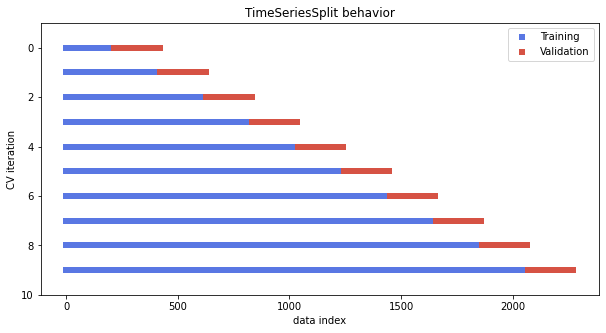

In [12]:
from sklearn.model_selection import TimeSeriesSplit
cv=TimeSeriesSplit(n_splits=10)

fig, ax = plt.subplots(figsize=(10, 5))
for ii, (train, test) in enumerate(cv.split(x, y)):
       
    # Plot training and test indices
    l1 = ax.scatter(train, [ii] * len(train), c=[plt.cm.coolwarm(.1)], 
                    marker='_', lw=6)
    l2 = ax.scatter(test, [ii] * len(test), c=[plt.cm.coolwarm(.9)], 
                    marker='_', lw=6)
    ax.set(ylim=[10, -1], title='TimeSeriesSplit behavior', 
           xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

In [13]:
x_train=x.iloc[train,:-1].values
x_test=x.iloc[test,:-1].values
y_train=y.iloc[train].values
y_test=y.iloc[test].values
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2067, 1737), (2067,), (206, 1737), (206,))

# LSTM

In [14]:

# Data preparation for LSTM
trainX = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
testX = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [15]:
trainX.shape, testX.shape

((2067, 1, 1737), (206, 1, 1737))

In [16]:

	
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(trainX, y_train, epochs=60, batch_size=72, validation_data=(testX, y_test), verbose=2, shuffle=False)


Epoch 1/60
29/29 - 0s - loss: 0.4032 - val_loss: 0.3537
Epoch 2/60
29/29 - 0s - loss: 0.2914 - val_loss: 0.0869
Epoch 3/60
29/29 - 0s - loss: 0.2322 - val_loss: 0.1095
Epoch 4/60
29/29 - 0s - loss: 0.2350 - val_loss: 0.1267
Epoch 5/60
29/29 - 0s - loss: 0.2361 - val_loss: 0.1148
Epoch 6/60
29/29 - 0s - loss: 0.2700 - val_loss: 0.4615
Epoch 7/60
29/29 - 0s - loss: 0.3458 - val_loss: 0.2609
Epoch 8/60
29/29 - 0s - loss: 0.2767 - val_loss: 0.1719
Epoch 9/60
29/29 - 0s - loss: 0.2551 - val_loss: 0.1341
Epoch 10/60
29/29 - 0s - loss: 0.2633 - val_loss: 0.3105
Epoch 11/60
29/29 - 0s - loss: 0.2915 - val_loss: 0.1403
Epoch 12/60
29/29 - 0s - loss: 0.2537 - val_loss: 0.3293
Epoch 13/60
29/29 - 0s - loss: 0.2609 - val_loss: 0.1249
Epoch 14/60
29/29 - 0s - loss: 0.2919 - val_loss: 0.4357
Epoch 15/60
29/29 - 0s - loss: 0.3166 - val_loss: 0.1286
Epoch 16/60
29/29 - 0s - loss: 0.2625 - val_loss: 0.3080
Epoch 17/60
29/29 - 0s - loss: 0.2846 - val_loss: 0.1277
Epoch 18/60
29/29 - 0s - loss: 0.2484 - 

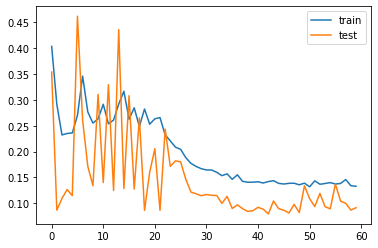

In [17]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
y_test_pred = model.predict(testX)

In [19]:
y_test_pred.shape

(206, 1)

In [20]:
# get the RMSE of test data
test_mse = MSE(y_test_pred, y_test)
test_rmse = math.sqrt(test_mse)
test_rmse

0.11293315903570966

In [21]:
test_orig_df=pd.DataFrame(y_test)
test_pred_df=pd.DataFrame(y_test_pred)
# Creating an empty Dataframe with column names only
y_test_df = pd.DataFrame(columns=[])

y_test_df['predicted test'] = test_pred_df.iloc[:,0].apply(lambda x: rev_min_max_func(x))
y_test_df['original test'] = test_orig_df.iloc[:,0].apply(lambda x: rev_min_max_func(x))



Text(0, 0.5, 'Inventory value')

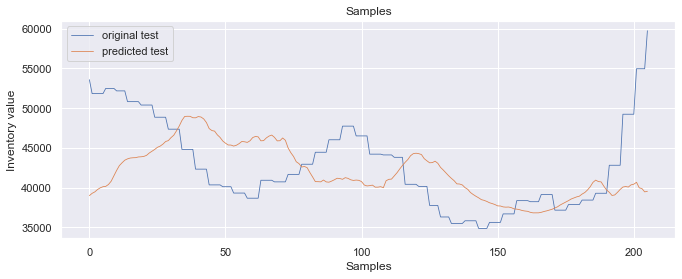

In [22]:
sns.set(rc={'figure.figsize':(11,4)})
y_test_df[['original test','predicted test']].plot(linewidth=0.8, title='Samples')
plt.xlabel('Samples')
plt.ylabel('Inventory value')

## Training Data results

In [23]:
y_train_pred = model.predict(trainX)

In [24]:
train_mse = MSE(y_train_pred, y_train)
train_rmse = math.sqrt(train_mse)
train_rmse

0.15220470665525018

In [25]:
train_orig_df=pd.DataFrame(y_train)
train_pred_df=pd.DataFrame(y_train_pred)

In [26]:
# Creating an empty Dataframe with column names only
y_train_df = pd.DataFrame(columns=[])

In [27]:
y_train_df['predicted train'] = train_pred_df.iloc[:,0].apply(lambda x: rev_min_max_func(x))
y_train_df['original train'] = train_orig_df.iloc[:,0].apply(lambda x: rev_min_max_func(x))
y_train_df['Index'] = train_orig_df.iloc[:,0].apply(lambda x: rev_min_max_func(x))

In [28]:
y_train_df

,predicted train,original train,Index
0,35944.299640,40020.0,40020.0
1,35912.316311,40020.0,40020.0
2,35843.832373,40020.0,40020.0
3,35834.358675,40197.0,40197.0
4,35812.294323,40197.0,40197.0
...,...,...,...
2062,38509.172211,52940.0,52940.0
2063,38484.534453,53582.0,53582.0
2064,38477.987314,53582.0,53582.0
2065,38554.830217,53582.0,53582.0


Text(0, 0.5, 'Inventory value')

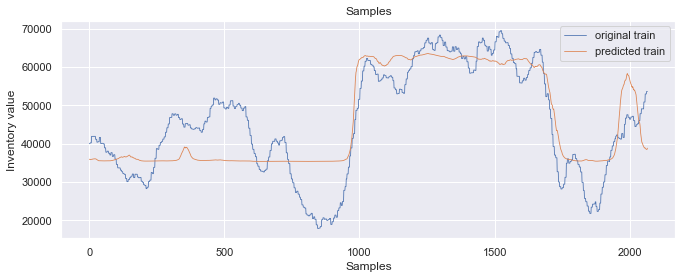

In [29]:
sns.set(rc={'figure.figsize':(11,4)})
y_train_df[['original train','predicted train']].plot(linewidth=0.8, title='Samples')
plt.xlabel('Samples')
plt.ylabel('Inventory value')

# Random Forest 

In [30]:
rf = RandomForestRegressor(verbose=1)

In [31]:
rf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.9min finished


RandomForestRegressor(verbose=1)

## Result on testing data

In [32]:
pred_test_rf = rf.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


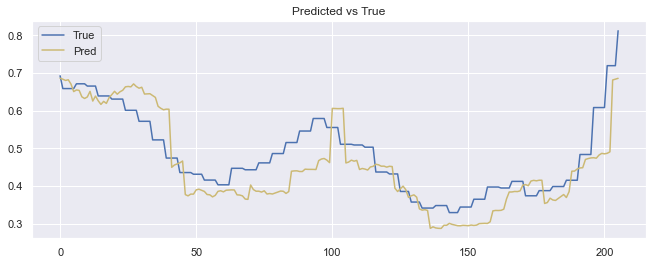

In [33]:
plt.plot(y_test, 'b')
plt.plot( pred_test_rf, 'y')
plt.legend(['True', 'Pred'])
plt.title('Predicted vs True')
plt.show()

In [34]:
#get the RMSE of test data
RF_test_mse = MSE(y_test, pred_test_rf)
RF_test_rmse = math.sqrt(RF_test_mse)
RF_test_rmse

0.06566649714872207

## Result on training data

In [35]:
pred_train = rf.predict(x_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


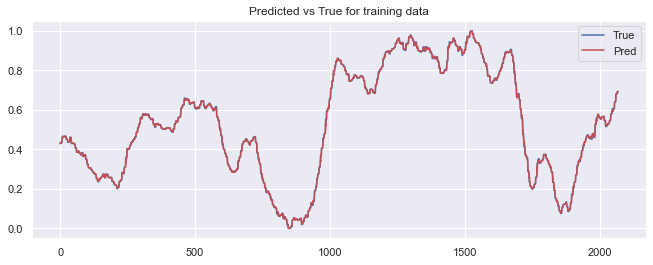

In [36]:
plt.plot(y_train, 'b')
plt.plot( pred_train, 'r')
plt.legend(['True', 'Pred'])
plt.title('Predicted vs True for training data')
plt.show()

In [37]:
#get the RMSE of train data
RF_train_mse = MSE(y_train, pred_train)
RF_train_rmse = math.sqrt(RF_train_mse)
RF_train_rmse

0.004962511131588873

In [38]:
train_index_df=x.iloc[train,-1]
test_index_df=x.iloc[test,-1]

In [39]:
test_index_df.describe()

count    206.000000
mean       0.954886
std        0.026237
min        0.909771
25%        0.932328
50%        0.954886
75%        0.977443
max        1.000000
Name: 1739, dtype: float64

## Visualization on real values

In [40]:
test_orig_rf_df=pd.DataFrame(y_test)
test_pred_rf_df=pd.DataFrame(pred_test_rf )


# Creating an empty Dataframe with column names only
y_test_rf_df = pd.DataFrame(columns=[])


y_test_rf_df['predicted test'] = test_pred_rf_df.iloc[:,0].apply(lambda x: rev_min_max_func(x))
y_test_rf_df['original test'] = test_orig_rf_df.iloc[:,0].apply(lambda x: rev_min_max_func(x))
#y_test_rf_df['test index'] = test_index_df.iloc[:,0].apply(lambda x: rev_min_max_func(x))
#y_test_df['train index'] = train_index_df.iloc[:,0].apply(lambda x: rev_min_max_func(x))

In [41]:
y_test_rf_df.describe()

,predicted test,original test
count,206.000000,206.000000
mean,41215.457670,42702.320388
std,6091.880952,5406.438069
min,32718.360000,34882.000000
25%,37307.275000,38445.000000
50%,39305.160000,40937.000000
75%,42961.722500,46516.000000
max,53252.250000,59741.000000


In [42]:
y_test_rf_df['test index'] = test_index_df.apply(lambda x: rev_index(x))

In [43]:
max_val_index = max(df_all['input_index'])
min_val_index = min(df_all['input_index'])
ind_val_test = (test_index_df*(max_val_index - min_val_index)) + min_val_index


In [44]:
ind_val_test.iloc[:].values

array([2116., 2117., 2118., 2119., 2120., 2121., 2122., 2123., 2124.,
       2125., 2126., 2127., 2128., 2129., 2130., 2131., 2132., 2133.,
       2134., 2135., 2136., 2137., 2138., 2139., 2140., 2141., 2142.,
       2143., 2144., 2145., 2146., 2147., 2148., 2149., 2150., 2151.,
       2152., 2153., 2154., 2155., 2156., 2157., 2158., 2159., 2160.,
       2161., 2162., 2163., 2164., 2165., 2166., 2167., 2168., 2169.,
       2170., 2171., 2172., 2173., 2174., 2175., 2176., 2177., 2178.,
       2179., 2180., 2181., 2182., 2183., 2184., 2185., 2186., 2187.,
       2188., 2189., 2190., 2191., 2192., 2193., 2194., 2195., 2196.,
       2197., 2198., 2199., 2200., 2201., 2202., 2203., 2204., 2205.,
       2206., 2207., 2208., 2209., 2210., 2211., 2212., 2213., 2214.,
       2215., 2216., 2217., 2218., 2219., 2220., 2221., 2222., 2223.,
       2224., 2225., 2226., 2227., 2228., 2229., 2230., 2231., 2232.,
       2233., 2234., 2235., 2236., 2237., 2238., 2239., 2240., 2241.,
       2242., 2243.,

In [45]:
y_test_rf_df['test index']=ind_val_test.iloc[:].values


In [46]:
y_test_rf_df

,predicted test,original test,test index
0,53252.25,53582.0,2116.0
1,53113.50,51836.0,2117.0
2,52947.50,51836.0,2118.0
3,53040.97,51836.0,2119.0
4,52448.13,51836.0,2120.0
...,...,...,...
201,42987.24,54965.0,2317.0
202,43185.01,54965.0,2318.0
203,53008.92,54965.0,2319.0
204,53116.59,54965.0,2320.0


In [47]:
combined.head()

,SeriesDate,Inventory,Date,CL,Bakken,MID,LLS,Bakken.1,MID.1,LLS.1,...,2&12,3&4,3&5,3&6,3&7,3&8,3&9,3&10,3&11,3&12
0,2011-01-03,37493,2011-01-03,91.55,88.08,90.99,97.44,3.47,0.56,-5.89,...,-2.40,-0.58,-0.99,-1.31,-1.51,-1.63,-1.70,-1.75,-1.78,-1.69
1,2011-01-04,37493,2011-01-04,89.38,85.81,88.63,95.83,3.57,0.75,-6.45,...,-3.33,-0.75,-1.31,-1.74,-2.01,-2.19,-2.30,-2.39,-2.47,-2.43
2,2011-01-05,37493,2011-01-05,90.30,85.44,89.73,97.45,4.86,0.57,-7.15,...,-3.80,-0.84,-1.48,-1.99,-2.32,-2.53,-2.66,-2.76,-2.85,-2.83
3,2011-01-06,37493,2011-01-06,88.38,83.98,87.57,95.82,4.40,0.81,-7.44,...,-4.55,-0.94,-1.64,-2.19,-2.56,-2.82,-3.02,-3.19,-3.35,-3.40
4,2011-01-07,37376,2011-01-07,88.03,85.90,87.51,95.01,2.13,0.52,-6.98,...,-3.90,-0.81,-1.42,-1.90,-2.23,-2.47,-2.65,-2.79,-2.92,-2.95


In [48]:
2
	
# Merge two Dataframes on index of both the dataframes
merged_df = y_test_rf_df.merge(combined, left_index=True, right_index=True)
#merged_df=merged_df.set_index('Date')

### Plot with complete date value

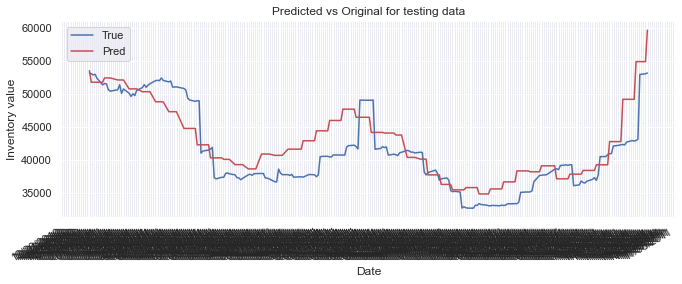

In [49]:
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gcf().autofmt_xdate()

plt.plot(merged_df.Date.values,merged_df['predicted test'].values, 'b')
plt.plot(merged_df.Date.values, merged_df['original test'].values, 'r')
plt.legend(['True', 'Pred'])
plt.title('Predicted vs Original for testing data')

plt.xlabel('Date')
plt.ylabel('Inventory value')
plt.gcf().autofmt_xdate()
plt.show()

### Plot with auto date value

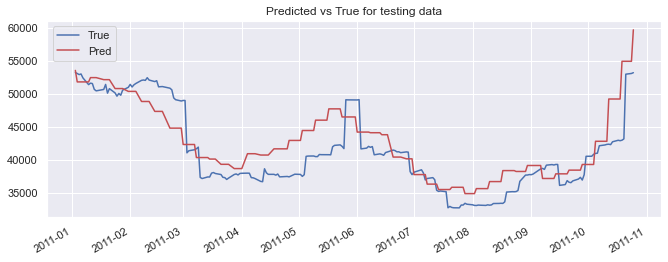

In [54]:
plt.plot(merged_df.Date.values,merged_df['predicted test'].values, 'b')
plt.plot(merged_df.Date.values, merged_df['original test'].values, 'r')
plt.legend(['True', 'Pred'])
plt.title('Predicted vs True for testing data')
plt.gcf().autofmt_xdate()
plt.show()

# Generating  tree picture for RF

In [55]:
df_input=df_all.iloc[:,3:]
features_list=list(df_input.columns)

In [56]:
len(features_list)

1737

In [64]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import os
tree = rf.estimators_[5]# Import tools needed for visualization
from sklearn.tree import export_graphviz
os.environ['PATH'] = os.environ['PATH']+';' + r'X:\Program Files\Graphviz\bin'
tree = rf.estimators_[5]# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = features_list, rounded = True, precision = 1)# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file


In [65]:
graph.write_png('tree.png')

In [62]:
from sklearn.model_selection import RandomizedSearchCV

# Random Forest with Grid Search


In [63]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfgs = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfgs, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
